# Master M2 MVA 2021/2022 - Introduction to (deep) Probabilistic Graphical Models - Homework 2

CHAUVEAU Marion & SOTO David 14/01/2022

## 1 - Gaussian processes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itertools
import pandas as pd

In [ ]:
#We read the data
path = '/Users/marion/Desktop/MVA/Cours MVA/Probabilistic graphical models/HW2/UScrimes.csv'
Data = pd.read_csv(path)
Data_crime = Data.to_numpy()[:,1:].astype('float')
print(Data_crime.shape)

#We keep 75% of the data set for learning and 25% for test
learning_ind = np.random.choice(np.arange(50),int(0.75*50),False)
test_ind = np.delete(np.arange(50),learning_ind)
Y = Data_crime[:,0]
X = Data_crime[:,1:]
X = (X - np.mean(X,axis=0))/np.std(X,axis = 0)
Y = (Y - np.mean(Y,axis=0))/np.std(Y,axis = 0)
y_learn = Y[learning_ind]
x_learn = X[learning_ind,:]
y_test = Y[test_ind,]
x_test = X[test_ind,]

(50, 3)


### 1. Learning

We want to maximize the log-likelihood $h(\theta) = \log(p(Y|X,\theta))$ with respect to the parameters. 
We write :

$h(\theta) = -\frac{n}{2}\log(2\pi) - \frac{1}{2}\log(|C|) - \frac{1}{2}y^{T}C^{-1}y$

We compute the derivative with respect to a parameter $\theta_k$ in the covariance function : 

$\frac{\partial h}{\partial \theta_k} = -\frac{1}{2}Tr(C^{-1}\frac{\partial C}{\partial \theta_k}) + \frac{1}{2}y^{T}C^{-1}\frac{\partial C}{\partial \theta_k}C^{-1}y$

To find the good parameters setting we will then use a gradient descent method. 

In [ ]:
def kernel_fct(xi,xj,theta):
	kernel = theta[0]*np.exp(-.5*theta[1]*np.sum((xi-xj)**2))+theta[2]+theta[3]*np.dot(xi.T,xj)
	return kernel

def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [ ]:
def compute_grad(theta,x,y):
	n = len(y)
	C = np.zeros((n,n))
	grad = np.zeros(5)
	grad_theta = np.zeros((5,n,n))
	grad_theta[4] = np.eye(n)
	grad_theta[2] = np.ones((n,n))
	for i in range(n):
		for j in range(i,n):
			C[i,j] = kernel_fct(x[i],x[j],theta)
			grad_theta[0,i,j] = np.exp(-.5*theta[1]*np.sum((x[i]-x[j])**2))
			grad_theta[1,i,j] = -.5*np.sum((x[i]-x[j])**2)*theta[0]*np.exp(-.5*theta[1]*np.sum((x[i]-x[j])**2))
			grad_theta[3,i,j] = np.dot(x[i].T,x[j])
	C = symmetrize(C)
	C += np.eye(n)*theta[4]
	grad_theta[0] = symmetrize(grad_theta[0])
	grad_theta[1] = symmetrize(grad_theta[1])
	grad_theta[3] = symmetrize(grad_theta[3])
	C_inv = np.linalg.inv(C)
	C_det = np.linalg.det(C)
	for t in range(5):
		grad[t] = .5*(y.T @ C_inv @ grad_theta[t] @ C_inv @ y) - .5*np.trace(C_inv @ grad_theta[t])
	log_like = -.5*(np.log(2*np.pi)*n + np.log(C_det) + (y.T @ C_inv @ y))
	return grad,log_like

In [ ]:
#optimisation pour trouver theta
def Gradient_ascent(x,y,MaxIter):
	theta = np.random.uniform(0,1,5)
	theta_k = np.zeros(5)
	Log = []
	eta = 1/4000 #learning rate
	for k in range(MaxIter):
		#print(eta)
		grad_log_like,log_like = compute_grad(theta,x,y)
		#print(grad_log_like)
		Log.append(log_like)
		for a in range(len(theta)):
			theta_k[a] = theta[a] + eta*grad_log_like[a]
		theta = np.copy(theta_k)
	return theta,Log

In [ ]:
Niter = 2000
theta,Log = Gradient_ascent(x_learn,y_learn,Niter)

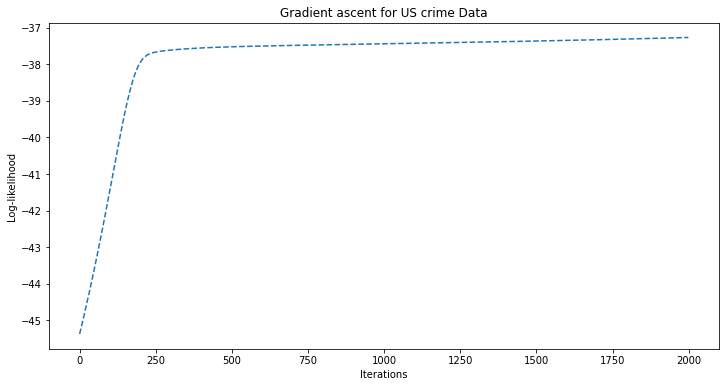

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(np.arange(Niter),Log,'--',color = 'tab:blue')
plt.title('Gradient ascent for US crime Data')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')
plt.show()

As expected the log-likelihood increases at each iteration.

In [ ]:
print(theta)

[0.4906856  0.22625018 0.41270321 0.1902611  0.31201369]


### 2. Prediction

**Write a complete set of functions in R or Python implementing the prediction GP step, i.e. the prediction $\hat{y}$ for a new observation x.**

In [ ]:
def Prediction_GP(x, x_s, theta):
    """
    K = K(X, X) 
    K_s = K(X_*, X)
    K_s = K(X_*, X_*)
    with X_* a new data point
    """
    
    n = x.shape[0]
    n_s = x_s.shape[0]

    K = [kernel_fct(i, j, theta) for (i, j) in itertools.product(x, x)]
    K = np.array(K).reshape(n, n)
    
    K_s2 = [kernel_fct(i, j, theta) for (i, j) in itertools.product(x_s, x_s)]
    K_s2 = np.array(K_s2).reshape(n_s, n_s)
    
    K_s = [kernel_fct(i, j, theta) for (i, j) in itertools.product(x_s, x)]
    K_s = np.array(K_s).reshape(n_s, n)

    y_pred = np.dot(K_s, np.dot(np.linalg.inv(K + (theta[4])*np.eye(n)), y_learn.reshape([n, 1])))
    y_pred = np.reshape(y_pred,(y_pred.shape[0],))
    
    return y_pred

In [ ]:
y_GP = Prediction_GP(x_learn, x_test, theta)

In [ ]:
#RMSE Gaussian process
RMSE_GP = np.sqrt(np.sum((y_GP-y_test)**2)/len(y_GP))
print('RMSE with Gaussian process : ', RMSE_GP)

RMSE with Gaussian process :  0.6327570915912002


**Linear Model** : Let ${ \left\{(x_i​,y_i​) \right\} }_{1⩽i⩽n}$ $\subset \mathbb{R}^{2} \times \mathbb{R}$ be a i.i.d sample of n observations. 

We have $\forall i=1,...,n$,  $y_i =  w^T x_i + b$.

Using the matrix notations, we have : $Y = X\theta $ 
with : 

$$Y =
\begin{pmatrix} 
y_{1}  \\
\vdots \\
y_{n} \\
\end{pmatrix} \\$$

$$\theta =
\begin{pmatrix} 
w_{1}  \\
\vdots \\
w_{d} \\
b
\end{pmatrix} \\$$


$$X =
 \begin{pmatrix} 
x_{1}^\top & 1  \\
\vdots & \vdots \\
x_{n}^\top & 1
\end{pmatrix} \\$$

We obtain $\theta$ by minimizing the least square error :
$$
\theta^{*} \in \underset{\theta \in \mathbb{R}^{d+1}}{\arg\min} \|{X \theta - Y}\|_{2}^{2}
$$

It gives the following equation :
$$\theta^{*\mathsf{T}} X^{\mathsf{T}} X \theta^{*} + Y^{\mathsf{T}} Y - 2 \theta^{*\mathsf{T}} X^{\mathsf{T}} Y = 0$$

And we finally get :
$$
\theta^{*} = (X^{\mathsf{T}} X)^{-1} X^{\mathsf{T}} Y
$$

In [ ]:
def linear_reg(X_train,Y_train):
	n = X_train.shape[0]
	X = np.column_stack((X_train,np.ones((n,1))))
	Pseudo_inv_X = np.linalg.pinv(X)
	Theta = np.dot(Pseudo_inv_X,Y_train)
	return Theta

In [ ]:
Theta = linear_reg(x_learn,y_learn)
x_test_one = np.column_stack((x_test,np.ones((x_test.shape[0],1))))
y_pred = x_test_one @ Theta
#RMSE linear model
RMSE_LM = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_pred))
print('RMSE with simple linear model : ', RMSE_LM)
#RMSE Gaussian process
print('RMSE with Gaussian process : ', RMSE_GP)

RMSE with simple linear model :  0.6613030919548772
RMSE with Gaussian process :  0.6327570915912002


### Comments : 

Slightly better results are obtained with the Gaussian process and the inference process is robust. The Gaussian process is less constraining and predicts new data a little better. The difference between the two models would perhaps be more striking with more data and test data that differs more from the training data.

## 2 - IWAE

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

**Loading MNIST and binarising it**

In [3]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

11501568/11490434 [==============================] - 0s 0us/step


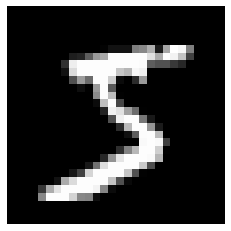

In [4]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

In [5]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

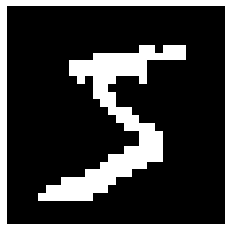

In [6]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

**Specifying our graphical model**

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a keras sequential model.

In [7]:
d = 10 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

In [8]:
h = 100 # number of hidden units

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28)
])

Note that the decoder needs to output probabilities, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.

### 1. Ancestral sampling

**Implement a function that performs ancestral sampling for this deep latent variable model, and show 5 sampled images from the initialised model.**

In [9]:
#function that performs ancestral sampling
def ancestral_sampling(p_z, decoder,N_sampl):
  plt.subplots(1,N_sampl,figsize = (20,8))
  for n in range(1,N_sampl+1):
    # sample z from the prior
    z = p_z.sample()
    z = np.reshape(z,(1,10))
    # compute parameter for the bernoulli
    pi_theta_z = np.array( decoder(z) ).reshape((28,28))

    # sample pixel from the bernoulli
    pixels_image = tfp.distributions.Bernoulli(logits = pi_theta_z).sample()
    plt.subplot(1,N_sampl,n)
    plt.imshow(pixels_image, cmap='gray' )
    plt.axis('off')

  plt.show()

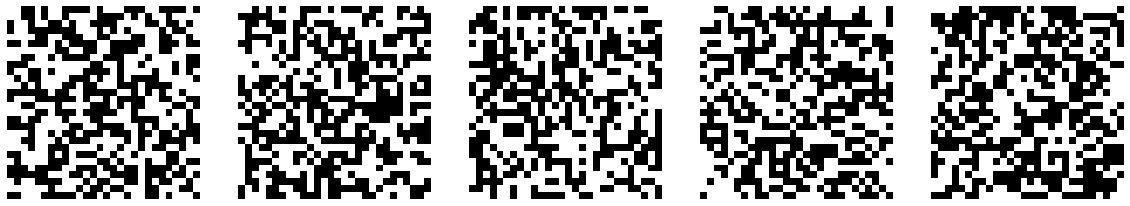

In [ ]:
ancestral_sampling(p_z, decoder,5)

### 2. Training

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\gamma ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\gamma ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\gamma ( \mathbf{x} ), \mathbf{s}_\gamma ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [10]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(2*d) # 2*d because we need both the mean and the diagonal of the covariance of q(z|x)
])

The **IWAE objective** is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_{ik}){p(\mathbf{z}_{ik})}}{{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}_i)}} \right]
$$

**Create a function that computes an unbiased estimate of the IWAE bound, and optimise it to train the model. You are allowed to use TF probability to avoid implementing the reparametrisation trick, and you are allowed to use keras for training. What are the values of the train/test IWAE bounds after training?**

In [11]:
#Function that compute the IWAE bound
#@tf.function
def compute_IWAE(image_batch,K): #batch_size):
	"""Args : K = order of the IWAE bound
	   Return : IWAE bound 
	"""
	IWAE = 0
	for im,_ in image_batch:
		image = tf.reshape(im,(1,28*28))
		#compute output of the encoder
		encoder_out = encoder(image)

		#get mu_gamma and diag(S_gamma) from the decoder_out of size 2*d
		mu_gamma = encoder_out[0,:d]
		sigma_gamma = tf.exp(encoder_out[0,d:]) #we take exp to have positive numbers
	
		# the approximate posterior
		q_gamma = tfd.Independent(tfd.Normal(loc = mu_gamma, scale = sigma_gamma),reinterpreted_batch_ndims=1) 

		#we sample z from the approximate posterior
		z_sampl = q_gamma.sample(K)

		#we compute output of z_sampl through the decoder
		z_sampl = tf.reshape(z_sampl,(K,d))
		decoder_out = decoder(z_sampl)
	
		#The proba of x knowing z follows
		p_theta = tfd.Independent(tfd.Bernoulli(logits = decoder_out), reinterpreted_batch_ndims = 1)

		#IWAE bound
		IWAE += tf.reduce_mean(tfp.math.reduce_weighted_logsumexp(p_theta.log_prob(image) + p_z.log_prob(z_sampl) - q_gamma.log_prob(z_sampl), axis=0))

	return IWAE

In [12]:
#function that makes batches from the dataset 
def create_dataset(images,y,batch_size):
	"""return Set that contains only a batch of images"""
	ind_batch = np.random.choice(np.arange(images.shape[0]),batch_size,False).astype(int)
	image_batch = images[ind_batch]
	y_nump = y_train.numpy()[ind_batch]
	y_batch = tf.constant(y_nump)
	Set = tf.data.Dataset.from_tensor_slices((image_batch,y_batch))
	Set = Set.shuffle(batch_size) #6000 images
	return Set

In [13]:
#function that optimise IWAE bound to train the model
def train_model(training_images,training_y,K,batch_size,Niter):
    model_params = list(encoder.trainable_variables) + list(decoder.trainable_variables)
    optimizer = tf.keras.optimizers.Adam(0.001)
    for t in range(Niter):
        #We create the batch
        batch_set = create_dataset(training_images,training_y,batch_size)
        with tf.GradientTape() as tape:
            #we compute IWAE bound 
            IWAE = compute_IWAE(batch_set,K)
            loss = -IWAE
        #optimisation step
        grad = tape.gradient(loss,model_params)
        optimizer.apply_gradients(zip(grad,model_params))
        print('------','Epoch ',t+1,'------')

In [ ]:
##### PARAMETERS #########
K = 1000 #With a high K we obtain better results
Nepoch = 100 #number of epochs
batch_size = 100 #size of batches
#########################

train_model(train_images,y_train,K,batch_size,Nepoch)

------ Epoch  1 ------
------ Epoch  2 ------
------ Epoch  3 ------
------ Epoch  4 ------
------ Epoch  5 ------
------ Epoch  6 ------
------ Epoch  7 ------
------ Epoch  8 ------
------ Epoch  9 ------
------ Epoch  10 ------
------ Epoch  11 ------
------ Epoch  12 ------
------ Epoch  13 ------
------ Epoch  14 ------
------ Epoch  15 ------
------ Epoch  16 ------
------ Epoch  17 ------
------ Epoch  18 ------
------ Epoch  19 ------
------ Epoch  20 ------
------ Epoch  21 ------
------ Epoch  22 ------
------ Epoch  23 ------
------ Epoch  24 ------
------ Epoch  25 ------
------ Epoch  26 ------
------ Epoch  27 ------
------ Epoch  28 ------
------ Epoch  29 ------
------ Epoch  30 ------
------ Epoch  31 ------
------ Epoch  32 ------
------ Epoch  33 ------
------ Epoch  34 ------
------ Epoch  35 ------
------ Epoch  36 ------
------ Epoch  37 ------
------ Epoch  38 ------
------ Epoch  39 ------
------ Epoch  40 ------
------ Epoch  41 ------
------ Epoch  42 ------
-

### 3. Sampling

In [ ]:
#encoder.save('model_MNIST.h5')

**Show a few samples from the model after training.**

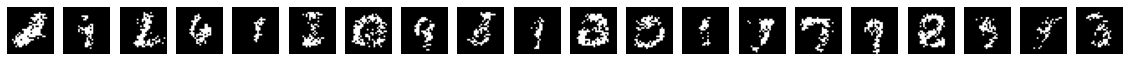

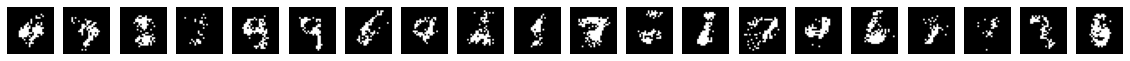

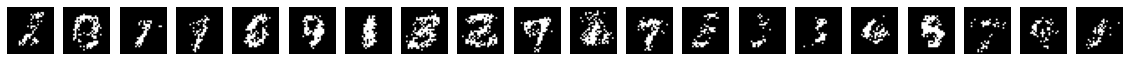

In [ ]:
ancestral_sampling(p_z, decoder,20)
ancestral_sampling(p_z, decoder,20)
ancestral_sampling(p_z, decoder,20)

The numbers obtained are not all really readable but the result is still satisfactory if we compare to the samples generated before the training of the model.

### 4. Importance sampling and visualisation

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [28]:
import numpy as np
batch_size = 30
d = 2
Train_set = create_dataset(train_images,y_train,batch_size) #create_dataset(train_images,y_train,batch_size)

In [29]:
def create_dataset(images,y,batch_size):
	Set = tf.data.Dataset.from_tensor_slices((images,y))
	Set = Set.shuffle(60000) #6000 images
	Set = Set.batch(batch_size)
	return Set

In [30]:
mu = []
for image_batch,_ in Train_set :
  image = tf.reshape(image_batch[0,:],(1,28*28))
  encoder_out = encoder(image)
  mu_gamma = encoder_out[0,:d]
  sigma_gamma = tf.exp(encoder_out[0,d:])
  mu.append(mu_gamma)


In [31]:
L = len(mu)
x = []
y = []
for i in range(L):
  x.append(np.array(mu[i][0]))
  y.append(np.array(mu[i][1]))

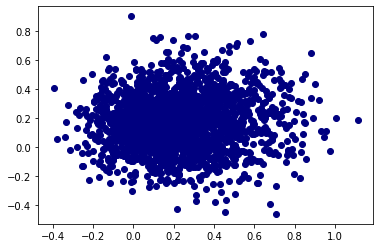

In [32]:
plt.scatter(x,y,c = 'navy')
plt.show()